# India Data

Here will download and subset NCEP reanalysis data, and read in files created from the DesInventar database. Then create a map showing the regions where disaster records are available, and how this relates to the resolution of the meteorological data. 

## Set up

### Libraries

In [1]:
#--- Import needed packages
import pandas as pd                                  # statistics packages 
import numpy  as np                                  # linear algebra packages
import matplotlib.pyplot as plt                      # plotting routines
import seaborn as sns                                # more plotting routines
import shapefile                                     # routines for using 'shapefiles'
import pickle                                        # routines for saving data as binaries
import urllib                                        # routines for interacting with websites

from mpl_toolkits.basemap import Basemap             # plotting routines for map making
from matplotlib import gridspec                      # plotting routines for multiple plots
from netCDF4 import Dataset                          # routines for interacting with NetCDF files

from matplotlib import cm                            # more plotting routines
from matplotlib.collections import LineCollection    # more plotting routines

from cdo import *                                    # routines for interacting with NetCDF files
cdo = Cdo()                                          #                    via an external program

In [2]:
# place graphics in the notebook document
%matplotlib inline

## Data

### Reanalysis 

Need to pull the renalysis data from NCEP's online database. Going to pull the full global files at first, so that have the data avaialbe if want to look at other regions of the world.  

In [3]:
#--- Pull in data from DesInvetar records

## Read file of reported heatwaves (original spreadsheet)
disrec = pd.read_csv('data/Heatwaves_database.csv')
# repair region name with space before name
disrec.loc[(disrec.Region==' Tamil Nadu'),'Region'] = 'Tamil Nadu'

## List countries in data set
country_names = list(set(disrec.Country))
# remove El Salvador; these events are from before start of observational record
country_names.pop(4) ;


## Map making

Wanted to look at where these regions actually are. As well, since there are a lot of regions, ended up color coding them by country to help me remember where they were in the world when looking at the analysis data.

### Color coding

Picked some colors, based losely off country flags. Try to have situations where don't really need to know which color means which, just have some variety in the images to trigger idea that this region is labelled differnetly from that one.

In [4]:
#--- Create a dictionary mapping country names to color data (RGB format) representing that country
country_colors = {'Albania':   sns.xkcd_rgb['brick red'],
                  'Honduras':  sns.xkcd_rgb['royal blue'],
                  'Colombia':  sns.xkcd_rgb['sky blue'],
                  'Mexico':    sns.xkcd_rgb['navy green'],
                  'Nepal':     sns.xkcd_rgb['off white'],
                  'India':     sns.xkcd_rgb['dusty orange'],
                  'Chile':     sns.xkcd_rgb['navy blue'],
                  'Peru':      sns.xkcd_rgb['faded red'],
                  'Argentina': sns.xkcd_rgb['dull yellow'],
                  'Ecuador':   sns.xkcd_rgb['marigold']}

### Abreviations

In [5]:
#--- Create a dictionary of country abreviations used in shapefile names
country_abs = {'Albania':   'ALB',
               'Honduras':  'HND',
               'Colombia':  'COL',
               'Mexico':    'MEX',
               'Nepal':     'NPL',
               'India':     'IND',
               'Chile':     'CHL',
               'Peru':      'PER',
               'Argentina': 'ARG',
               'Ecuador':   'ECU'}

Tried to set everthing on a map of the world (after some deliberation about what [projection](http://xkcd.com/977/) to use). Wanted to show how limited the segmant of the globe we were looking at, but individual countries blur together, and can't see much detail, or Albania for that matter.

### Globe

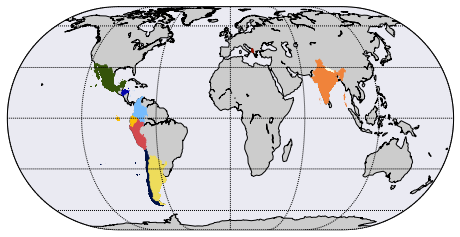

In [6]:
#--- Create world map
# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.
fig = plt.figure(figsize=(8,8))
m = Basemap(projection='eck4',lon_0=0,resolution='c') 
m.drawcoastlines()
m.fillcontinents()
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,360.,60.))
for country in country_names :
    m.readshapefile('data/'+country_abs[country]+'_adm0',country,
                    color=country_colors[country],
                    linewidth=0.5)[4].set_facecolors(country_colors[country])

plt.savefig("worldmap.png")

Want to show that not every country had reports for ever region, and how the grid spacing of the meterological fields imperfectly matches the actual region boundaries. Have currently set things so that a grid cell is considered informative about the political region as long some part of the region boundary is within 50kms of the grid point (cell center). Played around with a few things before settling on this. The distance is pretty conservative; as in tends towards considering information from outside the region, rather than excluding information from within, but still keeps a more "fair" evaluation, by not evaluating against grid cells which contain only a minimal amount of the geographical region. Considering that most political boundaries are linked to geographical features/divides, if only a small fraction of the region extends into another grid cell, would expect its weather to more correlated with that shown by cells over the rest of the region than that of this other area. Example of this can be seen for Uttar Pradesh (India), where a sliver of the region overlaps with a gird cell that is mostly representitive of the Himalayas, so it is not considered when calculating the warm spell durations.

### India

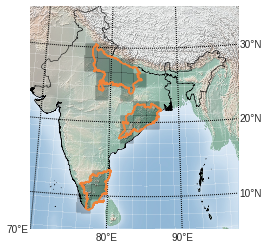

In [7]:
regions_shapefile = list(set(disrec.loc[(disrec.Country=='India'),'Region']))
## Create a map object
chart = Basemap(projection='lcc',resolution='c',
#              lat_0=20,lon_0=82.5,
              lat_0=20,lon_0=85,
              llcrnrlat=5,urcrnrlat=35,
              llcrnrlon=70,urcrnrlon=100)             
# add geographic features
chart.shadedrelief()
# draw parallels and meridians.
chart.drawparallels(np.arange(-90.,91.,10.),labels=[False,True,True,False])
chart.drawmeridians(np.arange(-180.,181.,10.),labels=[True,False,False,True])
# add country outline 
chart.readshapefile('./data/IND_adm0', 'IND0',drawbounds=True) ;
# Add region outlines, for regions in data set
chart.readshapefile('./data/IND_adm1', 'IND1',drawbounds=False) ;
for info, shape in zip(chart.IND1_info, chart.IND1):
    if info['NAME_1'] in regions_shapefile :
        x, y = zip(*shape) 
        chart.plot(x, y, marker=None,color=country_colors['India'])
## show area used to inform about meterological conditions over each region         
# load data file (previously combined all the regional mask files into one)
nc = Dataset('./data/India.masks.nc')
# read mask data
rm = nc.variables['region_mask'][:]
# get coordinates of data
lons = nc.variables['lon'][:]
lats = nc.variables['lat'][:]
# shift so that lines show grid box boundaries, 
#    rather than grid point locations
lons = lons - (1.875/2)
lats = lats + (1.9047/2)
# if in western hemisphere, need to label as 
#    "all the way round", rather than +/- 
# lons = lons - 360
# set coordinates list as grid of locations
lons, lats = np.meshgrid(lons,lats)
# overlay region masks 
chart.pcolormesh(lons,lats,rm,shading='flat',latlon=True, alpha=0.2) ;
plt.savefig('india.png')